In [13]:
import re
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split


pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:.2f}'.format
# 지수 표기법 해제

# 데이터 탐색

In [1]:
raw_data = pd.read_csv("vehicles.csv")

### 결측치 확인

In [15]:
def columns_na_percentage(columns):
    for column in columns:
        print("{} : ".format(column),round(100 -(len(raw_data['{}'.format(column)].dropna()) / len(raw_data)) * 100,2),"%", end='\n')

In [16]:
columns_na_percentage(raw_data.columns)

id :  0.0 %
url :  0.0 %
region :  0.0 %
region_url :  0.0 %
price :  0.0 %
year :  0.3 %
manufacturer :  4.47 %
model :  1.57 %
condition :  45.52 %
cylinders :  39.19 %
fuel :  0.78 %
odometer :  18.12 %
title_status :  0.6 %
transmission :  0.73 %
vin :  40.71 %
drive :  28.29 %
size :  67.12 %
type :  27.77 %
paint_color :  32.32 %
image_url :  0.0 %
description :  0.0 %
county :  100.0 %
state :  0.0 %
lat :  2.02 %
long :  2.02 %


In [5]:
msno.matrix(raw_data)

### 제외 컬럼
- 예측에 도움이 되지 않는 데이터
  - 'url','region_url','image_url','description',id','county'
- 위치정보
  - 'lat','long'
 
- 주관적 데이터
  - condition
- 고려해봐야할 컬럼
  - 'model' : 카테고리 너무 많음
  - 'vin' : 차량 고유 번호
  - 'size' : 결측치 50% 이상

In [3]:
start_df = raw_data[['id','price','year','odometer','drive','fuel','manufacturer','state','title_status','transmission','type','paint_color','cylinders','model','vin']]

### 결측치 제거

In [4]:
start_df = start_df.dropna(axis=0)
start_df.shape

(120082, 15)

### 중복되는 vin 제거 : 허위매물

In [5]:
start_df = start_df.loc[start_df['vin'].drop_duplicates(keep='last').index]
start_df.shape

(77339, 15)

- 고유값 : id, vin
- 종속변수 : 가격(price)
- 독립변수
  - 카테고리 : 
    - 연료(fuel)
    - 실린더(cylinder)
    - 변속기(transmission)
    - 구동 방식(drive)
    - 차량 크기(size)
    - 색깔(paint_color)
    - 차량 상태(title_status)
    - 차량 타입(type)
    - 제조사(manufacturer)
    - 연식(year)
  - 실수형 
    - 주행거리(odometer)

### 종속 변수의 특성

- 도메인지식 으로 확인 가능한 아웃라이어
    -  1~9까지 연속되는 숫자를 자릿수에 상관없이 지운다.
    -  한숫자가 반복되는 숫자를 자릿수에 상관없이 지운다.
  -  1000만불 이상 삭제
  -  100불 이하 삭제 (0불 포함)

### 종속 변수 및 연속형 독립변수 범위 설정

In [6]:
# 100불 이하, 100만불 이상 삭제
df = start_df[(start_df['price'] > 100) & (start_df['price'] <= 1000000)]

# 특정 패턴 숫자 제거
n = ""
for j in range(1,10):
    root_num = float(str(1)*j)
    for i in range(1,10):
        df = df[df['price'] != root_num * i]

for g in range(1,10):
    n =""
    for k in range(g,10):
        k = str(k)
        n += k
        df = df[df['price'] != float(n)]

    for m in range(1,9):
        if n[m:]:
            if n[m:] not in n[m:]:
                df = df[df['price'] != float(n[m:])]

    
for h in range(9,1,-1):
    n = ""
    for k in range(h,0,-1):
        k = str(k)
        n += k
        df = df[df['price'] != float(n)]
    for m in range(1,9):
        if n[m:]:
            if n[m:] not in n[m:]:
                df = df[df['price'] != float(n[m:])]

                # 독립변수 
# 2021년, 0년
df = df[(df['year'] != 2021) & (df['year'] != 0)]

# 주행거리 100 이하, 1000000만 이상, 
df = df[(df["odometer"] >= 100) & (df["odometer"] <= 1000000)]

df.shape

(71061, 15)

### 독립 변수의 특성

## 가격

In [7]:
df['price'].sort_values(ascending=False)[:25]

64504     1000000
163001     590000
447631     500000
379223     350000
317193     295000
401243     193982
171840     175000
489491     168000
182547     149995
199725     139995
366302     135000
220478     127003
415450     125000
114416     125000
345981     124900
135713     121995
70053      114950
379211     114566
482436     109995
18499      109500
244044     108950
113241     107500
61         105500
131685     105000
99774      103999
Name: price, dtype: int64

In [8]:
# 10만불 이상 1000만불 이하
under_one_mil = df[(df['price'] >= 100000) & (df['price'] <= 10000000)].sort_values(by=['price'],ascending=False)

In [12]:
# 26건
under_one_mil

,id,price,year,odometer,drive,fuel,manufacturer,state,title_status,transmission,type,paint_color,cylinders,model,vin
64504,7049736662,1000000,1970.0,195000.0,rwd,gas,volkswagen,az,salvage,manual,coupe,blue,4 cylinders,beetle,D0330181080013
163001,7047186613,590000,2004.0,159721.0,fwd,gas,lexus,fl,clean,automatic,SUV,silver,6 cylinders,rx330,GA31UX4C016048
447631,7048038726,500000,1994.0,186177.0,rwd,gas,mercedes-benz,pa,salvage,automatic,sedan,brown,6 cylinders,benz,WDBEA929E9F286519
379223,7047780521,350000,2017.0,190000.0,4wd,gas,jeep,ny,clean,automatic,SUV,white,6 cylinders,grand cherokee trail hok,1C4RJFLG7HC667688
317193,7041390316,295000,2016.0,32032.0,fwd,gas,mercedes-benz,mt,clean,automatic,SUV,black,6 cylinders,gle 350 4matic,4JGDA5HB6GA625276
401243,7045671330,193982,2019.0,7584.0,4wd,gas,mercedes-benz,oh,clean,automatic,SUV,white,8 cylinders,amg g 63,WDCYC7HJ3KX301396
171840,7048248566,175000,2012.0,61679.0,rwd,gas,nissan,fl,clean,automatic,truck,silver,8 cylinders,titan crew cab,1N6BA0ED4CN300582
489491,7049122510,168000,2014.0,33755.0,4wd,gas,ford,tx,clean,automatic,van,white,10 cylinders,e350 van,1FBSS3BS8EDA39989
182547,7040863555,149995,2010.0,95878.0,4wd,gas,honda,fl,clean,automatic,truck,blue,6 cylinders,ridgeline rtl,5FPYK1F58AB006970
199725,7048009986,139995,2019.0,649.0,4wd,hybrid,bmw,hi,clean,automatic,convertible,grey,3 cylinders,i8,WBY2Z6C52KVB82784


### 정상적인 가격을 보이는 모델
- 2019 :  i8 bmw , 
- 2017 :  r8 v10 audi , 
- 2014 : california ferrari, 
- 2016 :  martin rapide s aston-martin, 
- 2018 : amg gt mercedes-benz, 
- 2014 :  458 spider ferrari, 
- 2013 : 458 italia ferrari, 
- 2017 :  sprinter 2500 4x4 mercedes-benz, 
- 2018 : revel / sprinter mercedes-benz, 
- 2018 : amg gt mercedes-benz, 
- 2018 : amg gt mercedes-benz, 
- 2005 : f430 berlinetta f1 ferrari

In [13]:
true_id = [7033472903,7039773014,7049284671,7043599850,7049033507,7036156093,7049707044,7048009986,7041367828,7047810612,7045671330,7047378977]

In [14]:
len(true_id)

12

In [15]:
df = df[(df['price'] <= 100000) | df['id'].isin(true_id)]
df['year'] = df['year'].astype('int')
df.shape

(71047, 15)

# vincheck 사이트 정보와 비교를 통한 허위매물 제거

In [39]:
import requests

In [130]:
num = 1
for vin in df[(df['price'] >= 100) & (df['price'] <= 500)].sort_values(by='year',ascending=False)['vin']:
    try:
        url = 'https://marketvalue.vinaudit.com/getmarketvalue.php?key=1HB7ICF9L0GVH5Q&vin={}&mileage=null&country=USA'.format(vin)
        response = requests.get(url)
        response.json()
        price_search_result = []
        our_car = df[df['vin'] == vin]
        num += 1
        our_price = our_car['price'].values[0]
        below_price = response.json()['prices']['below']
        above_price = response.json()['prices']['above']
        print(num)
        if our_price < below_price*0.5 or our_price > above_price*1.5:
            price_search_result.append(vin)
        else:
            print("clear")
    except Exception as e:    
        print('예외가 발생했습니다.')

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
예외가 발생했습니다.
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
예외가 발생했습니다.
130
131
132
133
134
135
136
137
138
예외가 발생했습니다.
예외가 발생했습니다.
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
예외가 발생했습니다.
225
226
227
228
229
230
231
232
233
예외가 발생했습니다.
235
236
237
238
예외가 발생했습니다.
240
241
242
243
244
245
예외가 발생했습니다.
247
248
249
250
251
예외가 발생했습니다.
예외가 발생했습니다.
예외가 발생했습니다.
255
2

In [125]:
vin = "5FNYF5H95HB048060"
url = 'https://marketvalue.vinaudit.com/getmarketvalue.php?key=1HB7ICF9L0GVH5Q&vin={}&mileage=null&country=USA'.format(vin)

In [126]:
response = requests.get(url)

In [127]:
response.json()

{'vin': '5FNYF5H95HB048060',
 'vehicle': '2017 Honda Pilot Touring',
 'mileage': 40842,
 'success': True,
 'count': 181,
 'mean': 30646.55,
 'stdev': 2721,
 'certainty': 99,
 'period': ['2019-10-10', '2020-03-24'],
 'prices': {'average': 30646.55, 'below': 27925.55, 'above': 33367.55}}

In [117]:
# 차 가격
price_search_result = []
our_car = df[df['vin'] == vin]
our_price = our_car['price'].values[0]
below_price = response.json()['prices']['below']
above_price = response.json()['prices']['above']
if our_price < below_price*0.5 or our_price > above_price*1.5:
    price_search_result.append(vin)
else:
    print("clear")

In [118]:
price_search_result

['5FNYF5H95HB048060']

In [119]:
# 가격 100불 이상 500불 이하
df[(df['price'] >= 100) & (df['price'] <= 500)].sort_values(by='year',ascending=False)

,id,price,year,odometer,drive,fuel,manufacturer,state,title_status,transmission,type,paint_color,cylinders,model,vin
173866,7049546437,355,2019,18034.0,rwd,gas,nissan,fl,clean,automatic,pickup,red,6 cylinders,frontier sv,1N6AD0ER2KN726834
173859,7049582513,362,2019,21809.0,rwd,gas,nissan,fl,clean,automatic,pickup,black,6 cylinders,frontier sv,1N6AD0ER9KN723638
175166,7036367263,459,2019,17088.0,rwd,gas,chevrolet,fl,clean,automatic,pickup,silver,8 cylinders,silverado 1500 ld lt,2GCRCPEC1K1143928
473055,7038321476,490,2019,13942.0,fwd,gas,nissan,tn,clean,automatic,other,silver,6 cylinders,pathfinder sl,5N1DR2MN1KC605215
473157,7037973267,387,2019,14847.0,fwd,gas,hyundai,tn,clean,automatic,other,white,3 cylinders,santa fe sel 2.4,5NMS33AD7KH044373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
326641,7050066011,500,1992,999999.0,rwd,gas,ford,nc,missing,manual,truck,white,8 cylinders,f700,1FDPF70J7NYA08729
408000,7032919716,500,1992,252091.0,rwd,gas,chevrolet,oh,clean,automatic,coupe,red,8 cylinders,camaro,1g1fp23e3nL157836
495002,7049183828,350,1988,113038.0,fwd,gas,chevrolet,tx,clean,automatic,hatchback,grey,4 cylinders,nova hatchback,1Y1SK614XJZ055524
222204,7046276877,500,1987,135000.0,fwd,gas,nissan,in,clean,automatic,other,grey,4 cylinders,pulsar,JN1PN34S6HM048932


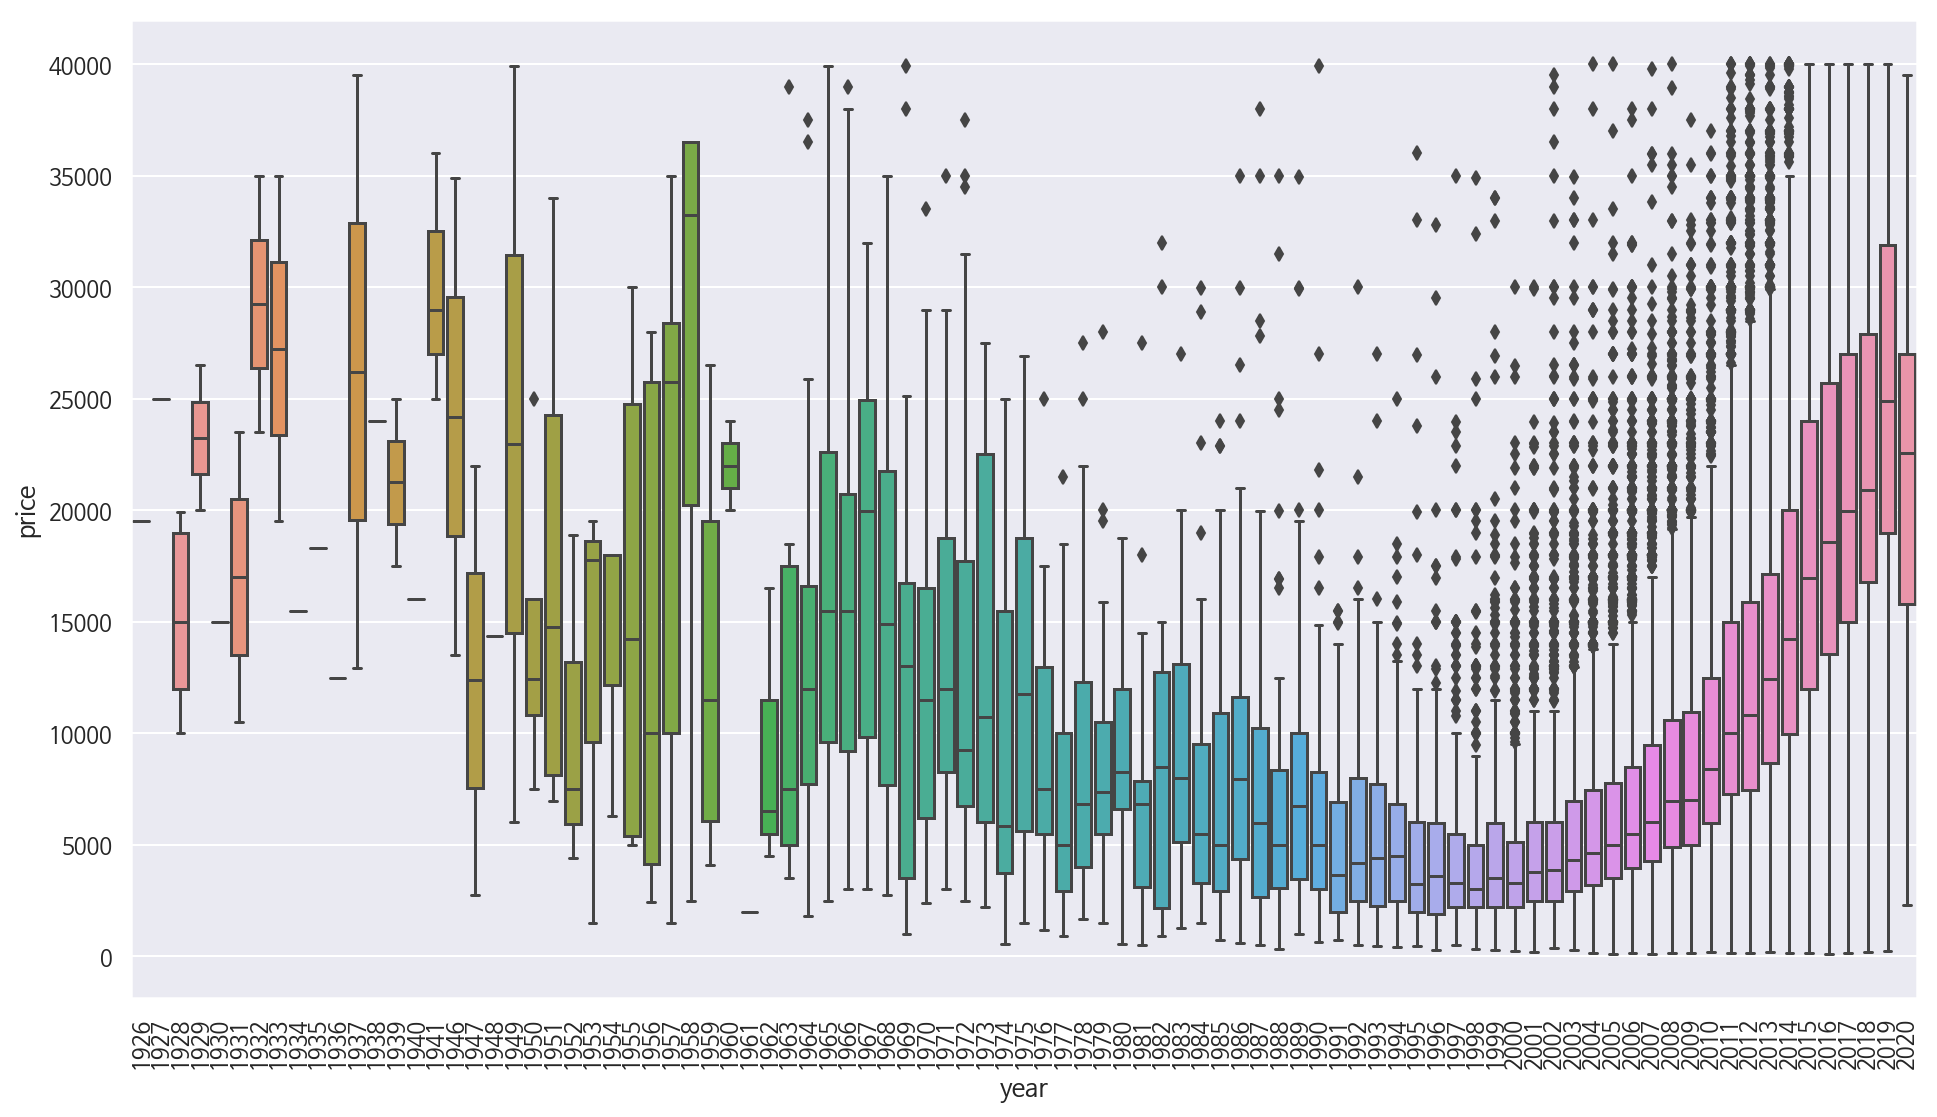

In [16]:
plt.figure(figsize=(16,9))

price_over_98pct = df["price"].quantile(.98)

plot_df = df[df['price'] < price_over_98pct]

sns.boxplot(x="year", y="price", data = plot_df)
plt.xticks(rotation=90)

plt.show()

# 연식

In [402]:
df['year'].value_counts().to_dict()

{2016: 5721,
 2013: 5501,
 2015: 5347,
 2014: 5262,
 2012: 5089,
 2011: 4755,
 2017: 4593,
 2008: 4125,
 2010: 3778,
 2007: 3693,
 2006: 3152,
 2018: 2909,
 2009: 2887,
 2005: 2452,
 2004: 2214,
 2003: 1739,
 2019: 1477,
 2002: 1252,
 2001: 1042,
 2000: 796,
 1999: 600,
 1998: 377,
 1997: 340,
 1996: 213,
 1995: 182,
 1994: 168,
 1993: 120,
 1992: 95,
 1990: 89,
 1991: 78,
 1989: 77,
 1988: 66,
 1987: 62,
 1986: 58,
 2020: 56,
 1972: 41,
 1978: 40,
 1966: 38,
 1984: 35,
 1985: 34,
 1979: 29,
 1971: 27,
 1965: 26,
 1974: 26,
 1976: 25,
 1968: 25,
 1970: 24,
 1969: 24,
 1967: 24,
 1977: 23,
 1964: 22,
 1981: 22,
 1983: 22,
 1980: 20,
 1973: 18,
 1975: 14,
 1982: 12,
 1963: 9,
 1956: 8,
 1957: 8,
 1959: 7,
 1958: 6,
 1951: 6,
 1953: 5,
 1955: 5,
 1928: 5,
 1932: 4,
 1950: 4,
 1962: 4,
 1931: 4,
 1952: 3,
 1941: 3,
 1954: 3,
 1929: 2,
 1949: 2,
 1960: 2,
 1948: 2,
 1947: 2,
 1937: 2,
 1946: 2,
 1933: 2,
 1939: 2,
 1936: 1,
 1930: 1,
 1961: 1,
 1927: 1,
 1940: 1,
 1926: 1,
 1934: 1,
 1938: 

# 모델 테스트

### linear_model.LinearRegression() 방법

In [145]:
X = df[df.columns.difference(['id','model','vin','price'])]
Y = df['price']
X = pd.get_dummies(data=X, drop_first=True)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

test_df = pd.concat([train_y,train_X],axis=1)

model = linear_model.LinearRegression() 
result = model.fit(X_train, Y_train)
predicted = result.predict(X_test)
r2_score(Y_test,predicted)
# plt.scatter(Y_test,predicted)

0.3600813587782994

### sm.OLS 방법

In [429]:
X = df[df.columns.difference(['id','model','vin','price'])]
Y = df['price']
X = pd.get_dummies(data=X, drop_first=True)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)

test_df = pd.concat([train_y,train_X],axis=1)

model = sm.OLS(X_train, Y_train)
result = model.fit()

# sm.OLS formula 방식

In [434]:
df.shape

(71061, 15)

In [415]:
# id, vin 분석에 불필요 해서 제거
# model 아직 데이터 정리가 안되어서 일단 제외
df = df[df.columns.difference(['id','vin','model'])]
len(df.columns)

12

In [ ]:
# 연식, 2000년 이상, 주행거리 10만 이하
# 제약 조건 없으면 모델 안돌아감
df = df[df['year'] >= 2000]
df = df[(df['odometer'] >= 100) &  (df['odometer'] <= 100000)]

# 각 컬럼별 조합 분석

In [422]:
from itertools import chain, combinations
combination_list =  list([list(s) for s in chain.from_iterable(combinations(df.columns.difference(['price','odometer','year']), r) for r in range(len(df.columns.difference(['price','odometer','year'])) + 1))])

In [423]:
summary_list = []
result_list = []
graph = []
error_msg = []
for i in combination_list[1:10]:    
    X_train, X_test = train_test_split(df[df.columns.difference(i)], test_size = .20, random_state = 9)
    try:
        model = sm.OLS.from_formula("price ~ scale(odometer) + C(year) + {}".format(" + ".join(X_train.columns.difference(i+['price','odometer','year']))),X_train)
        result = model.fit()
        summary_list.append(result)

        predict = result.predict(X_test)
        under_0 = len(predict[predict < 10])

        graph.append((X_test['price'],predict))
        result_list.append((",".join(i), round(r2_score(X_test['price'],predict),3),under_0))
    except Exception as e:    
        print('예외가 발생했습니다.')
        error_msg.append(e)

In [424]:
error_msg

[]

(-10000, 20000)

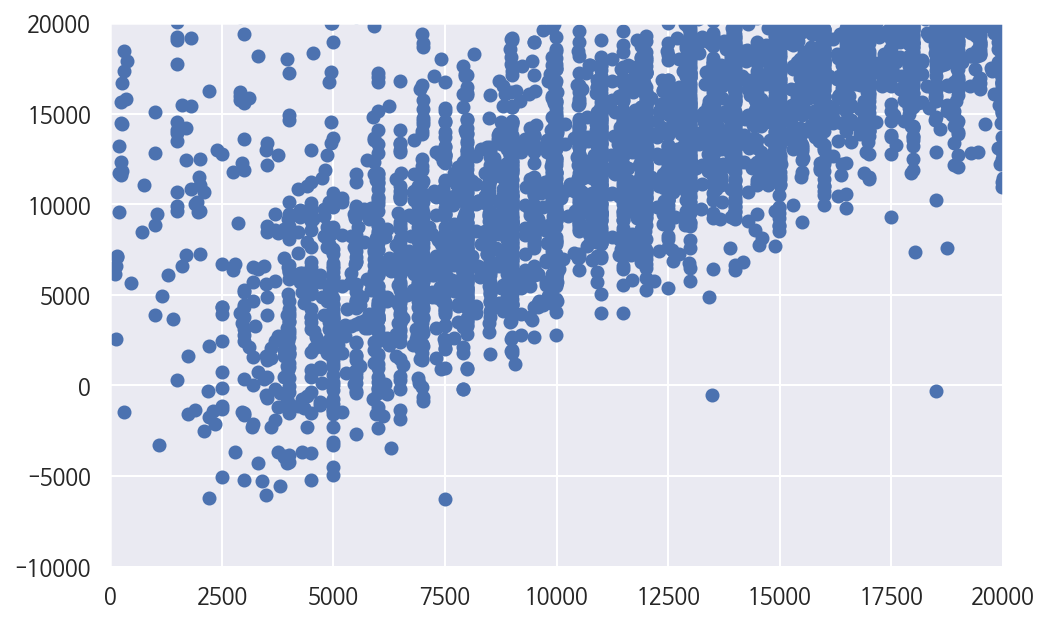

In [425]:
plt.scatter(graph[2][0],graph[2][1])
plt.xlim(-10,20000)
plt.ylim(-10000,20000)

# 주행거리 범위설정

In [443]:
df['odometer'].describe()

count     71061.00
mean     104241.56
std       61920.22
min         100.00
25%       58278.00
50%       99309.00
75%      141235.00
max     1000000.00
Name: odometer, dtype: float64

In [ ]:
result = []
error_msg = []
for i in range(10000,100000,10000):
    df_odo = df[df['odometer'] <= i]  
    train_X, test_X = train_test_split(df_odo,random_state=9, train_size=0.2)
    try:
        model = sm.OLS.from_formula("scale(price) ~ scale(odometer) + C(year) +{}".format(" + ".join(train_X.columns.difference(['price','odometer','year']))),train_X)
        fit = model.fit()
        pred_y = fit.predict(test_X)
        result.append(r2_score(test_X['price'], pred_y))
    except Exception as e:    
        print('예외가 발생했습니다.')
        error_msg.append(e)

예외가 발생했습니다.
예외가 발생했습니다.
예외가 발생했습니다.
예외가 발생했습니다.
예외가 발생했습니다.
예외가 발생했습니다.
예외가 발생했습니다.
예외가 발생했습니다.


In [ ]:
result

In [395]:
model = sm.OLS.from_formula("scale(price) ~ scale(odometer) + C(year) +{}".format("+".join(test_df.columns.difference(['id','price','odometer','year','vin']))),test_df)
fit = model.fit()